In [80]:
%matplotlib inline
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import ceil, log
from sklearn.base import BaseEstimator
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer

In [2]:
def add_map(mp, key, val):
    if key not in mp:
        mp[key] = val
    else:
        mp[key] += val

def make_data_entry(filename):
    res = {}
    res['is_spam'] = "spmsg" in filename
    with open(filename, 'r') as f:
        l = next(f)
        for n in l.split()[1:]:
            res[int(n)] = 1
        for l in f:
            for n in l.split():
                res[int(n)] = 1
    return res    

def make_dataset():
    files = glob.glob('data/part*/*.txt')
    entries = list(map(make_data_entry, files))
    return pd.DataFrame.from_dict(entries)

In [3]:
data = make_dataset().fillna(0)

In [4]:
data.head()

,is_spam,14486,80,196,64,1896,8962,14328,2130,16502,...,15561,15330,11289,547,15318,238,21957,1402,17219,19609
0,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def accuracy_score(true, predicted):
    return (predicted == true).sum() / len(true)

def f1_score(true, predicted):
    tp = ((predicted == 1) * (true == 1)).sum()
    rec = tp / (true == 1).sum()
    prec = tp / (predicted == 1).sum()
    return 2 * prec * rec / (prec + rec)

In [122]:
def simple_selector(probs):
    return np.argmax(probs, axis=1)

def threshold_selector(probs, threshold):
    return np.array([1 if p[1] - p[0] > threshold else 0 for p in probs])

def threshold_selector_factory(threshold):
    return lambda probs: threshold_selector(probs, threshold)

def recall0_selector(probs, true_classes, recall):
    diffs = np.array([p[1] - p[0] for p in probs])
    class0_diffs = np.sort(diffs[np.nonzero(true_classes == 0)])
    if (recall == 0):
        return np.array([1 if d >= class0_diffs[0] else 0 for d in diffs])
    else:
        k = ceil(class0_diffs.shape[0] * recall)
        print("Used threshold:", class0_diffs[k - 1])
        return np.array([1 if d > class0_diffs[k - 1] else 0 for d in diffs])

def recall0_selector_factory(true_classes, recall):
    return lambda probs: recall0_selector(probs, true_classes, recall)

In [118]:
class NaiveBayes(BaseEstimator):
    
    def __init__(self, smooth_coef=1e-5, lambdas=None, selector=simple_selector):
        self.smooth_coef = smooth_coef
        self.lambdas = lambdas
        self.selector = selector
        
    def fit(self, X, y):
        total_counts = np.sum(X, axis=0)
        total_words = np.sum(total_counts)
        classes = np.unique(y)
        
        if self.lambdas is None:
            self.lambdas = np.ones(classes.shape[0])
            
        self.classes = classes
        self.word_probas = np.zeros((classes.shape[0], total_counts.shape[0]))
        self.class_probas = np.zeros(classes.shape[0])
        for cl in classes:
            cl_count = y[y == cl].shape[0]

            # smooth_coef затем, чтобы не вышло нулевых вероятностей
            self.word_probas[cl] = (np.sum(X[y == cl], axis=0) + self.smooth_coef) / (cl_count + self.smooth_coef * y.shape[0])
            self.class_probas[cl] = float(cl_count) / y.shape[0]
    
    def class_log_proba(self, x, cl):
        return self.lambdas[cl] + np.log(self.class_probas[cl]) + np.sum(np.log(self.word_probas[cl][x > 0]))
    
    def predict_log_proba(self, X):
        probas = np.zeros((X.shape[0], self.classes.shape[0]))
        for i in np.arange(0, X.shape[0]):
            for cl in self.classes:
                probas[i][cl] = self.class_log_proba(X[i], cl)
        return probas
        
    def predict(self, X):
        probas = self.predict_log_proba(X)
        return self.selector(self.predict_log_proba(X))
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [119]:
def class_accuracy(y_test, y_pred, cl):
    y_cl = y_test[y_test == cl]
    y_pr = y_pred[y_test == cl]
    return float(np.sum(y_cl == y_pr)) / y_cl.shape[0]

In [51]:
X = data.drop('is_spam', axis=1).values
y = data['is_spam'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=43)

In [126]:
nb = NaiveBayes(selector=recall0_selector_factory(y_test, 1.0))
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Ham recall:", class_accuracy(y_test, y_pred, 0))
print("Spam recall:", class_accuracy(y_test, y_pred, 1))

Used threshold: 174.266376704
Ham recall: 1.0
Spam recall: 0.5612244897959183


In [127]:
nb1 = NaiveBayes(selector=threshold_selector_factory(174.0))
nb1.fit(X_train, y_train)
y_pred1 = nb1.predict(X_test)
print("Used threshold: 174.0")
print("Ham recall:", class_accuracy(y_test, y_pred1, 0))
print("Spam recall:", class_accuracy(y_test, y_pred1, 1))

Used threshold: 174.0
Ham recall: 0.9916666666666667
Spam recall: 0.5612244897959183


In [129]:
nb2 = NaiveBayes(selector=threshold_selector_factory(176.0))
nb2.fit(X_train, y_train)
y_pred2 = nb2.predict(X_test)
print("Used threshold: 176.0")
print("Ham recall:", class_accuracy(y_test, y_pred2, 0))
print("Spam recall:", class_accuracy(y_test, y_pred2, 1))

Used threshold: 176.0
Ham recall: 1.0
Spam recall: 0.5510204081632653


In [88]:
accuracy_score(y_test, y_pred)

0.80275229357798161

In [89]:
f1_score(y_test, y_pred)

0.71895424836601307

In [94]:
confusion_matrix(y_test, y_pred)

array([[120,   0],
       [ 43,  55]])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


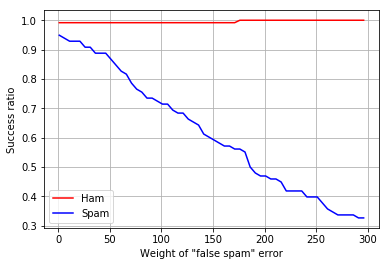

In [17]:
%time
ls = np.arange(1, 300, 5)
sc0 = []
sc1 = []

for l in ls:
    nbc = NaiveBayes(lambdas=[l, 1])
    nbc.fit(X_train, y_train)
    y_pred = nbc.predict(X_test)
    
    sc0.append(class_accuracy(y_test, y_pred, 0))
    sc1.append(class_accuracy(y_test, y_pred, 1))

plt.plot(ls, sc0, 'r-', ls, sc1, 'b-')
plt.xlabel('Weight of "false spam" error')
plt.ylabel('Success ratio')
plt.legend(['Ham', 'Spam'])
plt.grid()
plt.show()

In [92]:
nbc = NaiveBayes(lambdas=[1, 1])
nbc.fit(X_train, y_train)
y_pred = nbc.predict(X_test)
print('Ham recall: {}'.format(class_accuracy(y_test, y_pred, 0)))
print('Spam recall: {}'.format(class_accuracy(y_test, y_pred, 1)))

Ham recall: 0.9916666666666667
Spam recall: 0.9489795918367347


In [115]:
cv_acc_scores = cross_val_score(NaiveBayes(), X, y, scoring=make_scorer(accuracy_score), cv=10)
cv_acc_scores.mean()

0.97981651376146794

In [116]:
cv_f1_scores = cross_val_score(NaiveBayes(), X, y, scoring=make_scorer(f1_score), cv=10)
cv_f1_scores.mean()

0.97694031303192008